1. Считать в `pandas.DataFrame` любой источник данных: CSV, JSON, Excel-файл, HTML-таблицу и т.п.
   > Датасет должен содержать как минимум количественные признаки. Если категориальных нет, то пропустить пункты с временным убиранием категориальных признаков. Желательно наличие обоих типов признаков в датасете.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('smoker.csv')

print(df.head())
print(df.info())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


2. Датасет и подготовка данных, этап 1:
   - Привести описание датасета.
   - Осуществить предобработку данных (избавиться от `null`, убрать некоторые признаки и т.п.) - "подчистить данные".
   - Нормализовать численные данные.
   - Визуализировать `heatmap`-матрицу кореллированности признаков.
   - Визуализировать взаимосвязь между `target`-переменной и каждым из признаком (с использованием `srs.pairplot` или `pandas.plotting.scatter_matrix`). Лучше всего построить диаграмму попарного распределения между таргетом и каждым из признаков отдельно (пример с `sns.FacetGrid` в лекции).
   - Разбить выборку на обучающую и тестовую.
     > Из датафреймов обучающей и тестовой выборки необходимо временно убрать категориальные признаки (исходные датафреймы сохранить для 2 этапа).

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


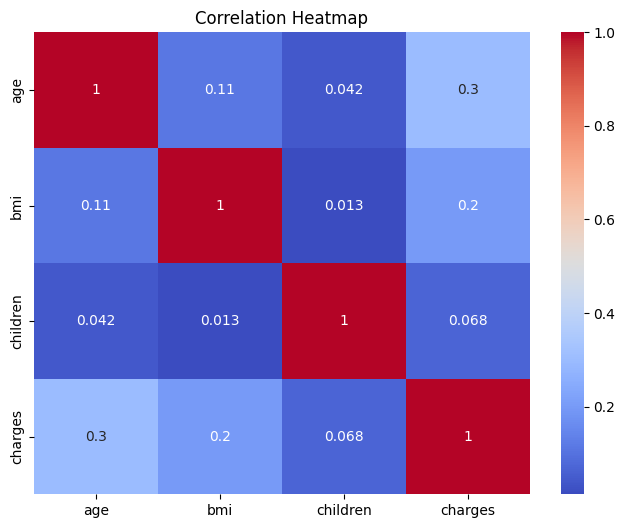

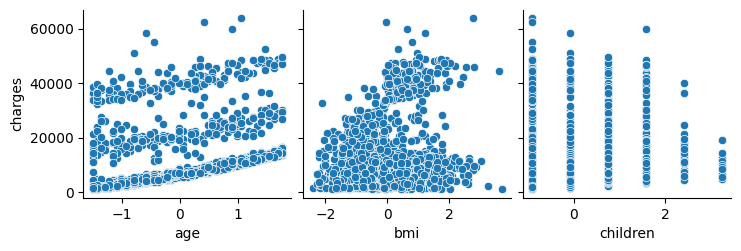

In [ ]:
print(df.isnull().sum())


df_num = df.drop(columns=['sex', 'smoker', 'region'])

scaler = StandardScaler()
numerical_cols = ['age', 'bmi', 'children']
df_num_scaled = pd.DataFrame(scaler.fit_transform(df_num[numerical_cols]), columns=numerical_cols)
df_num_scaled['charges'] = df['charges']

# Матрица корреляции
plt.figure(figsize=(8,6))
sns.heatmap(df_num_scaled.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

sns.pairplot(df_num_scaled, y_vars=['charges'], x_vars=numerical_cols)
plt.show()

X = df_num.drop('charges', axis=1)
y = df_num['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_raw, X_test_raw = X_train.copy(), X_test.copy()
y_train_raw, y_test_raw = y_train.copy(), y_test.copy()

3. Регрессия МНК:
   - Обучить модель линейной регрессии `LinearRegression`.
   - Вывести метрики $MSE$, $MAE$ и $R^2$ на тестовом наборе.
   - Вывести `model.coef_` и `model.intercept_`.
   - Построить график (`barh`) с важностью коэфициентов при соответствующих признаках (сверху вниз расположены коэффициенты по убыванию, а названия соответствующих признаков подписаны по вертикальной оси).

Linear Regression Metrics:
MSE: 131201335.65, MAE: 9181.31, R²: 0.15
Coefficients: [220.75776541 332.20247584 563.01943242]
Intercept: -6118.046178106708


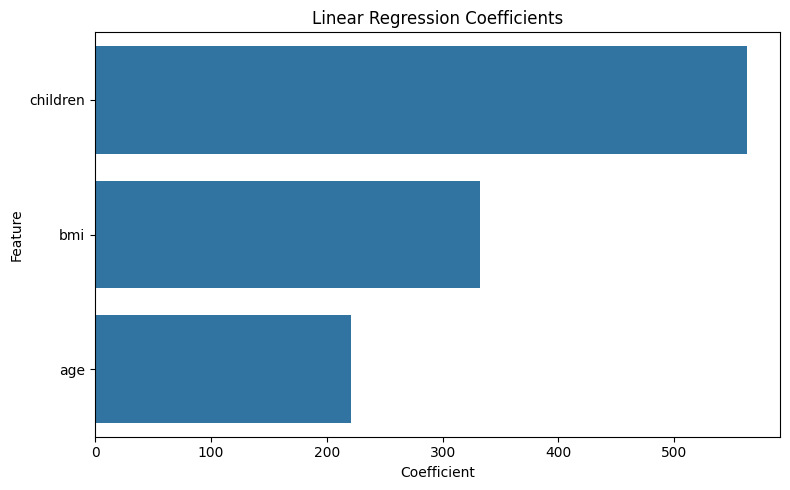

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
    return mse, mae, r2

print("Linear Regression Metrics:")
evaluate_model(y_test, y_pred)

print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)

coeff_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': lr.coef_})
coeff_df.sort_values(by='Coefficient', key=abs, ascending=False, inplace=True)
plt.figure(figsize=(8,5))
sns.barplot(x='Coefficient', y='Feature', data=coeff_df)
plt.title('Linear Regression Coefficients')
plt.tight_layout()
plt.show()

4. Для каждого вида регрессии (`Ridge`, `LASSO`, `Elastic Net`):
   - С использованием `GridSearchCV` осуществить подбор параметров регуляризации (`alpha` для `Ridge` и `LASSO`, `alpha` и `l1_ratio` для `Elastic Net`)
   - Вывести значения гиперпараметров, коэффициенты регрессии (`model.coef_` и `model.intercept_`) и значения метрик на тестовом наборе для наилучшей модели ($MSE$, $MAE$ и $R^2$).
   - Построить график (`barh`) с важностью коэфициентов при соответствующих признаках (сверху вниз расположены коэффициенты по убыванию, а названия соответствующих признаков подписаны по вертикальной оси).  
   
   > Запомнить лучшие модели для 2 этапа.


Ridge Best Params: {'alpha': 10}
Ridge Metrics:
MSE: 131200499.15, MAE: 9181.57, R²: 0.15
Coefficients: [220.77073813 332.11023775 559.46845751], Intercept: -6111.805291153063


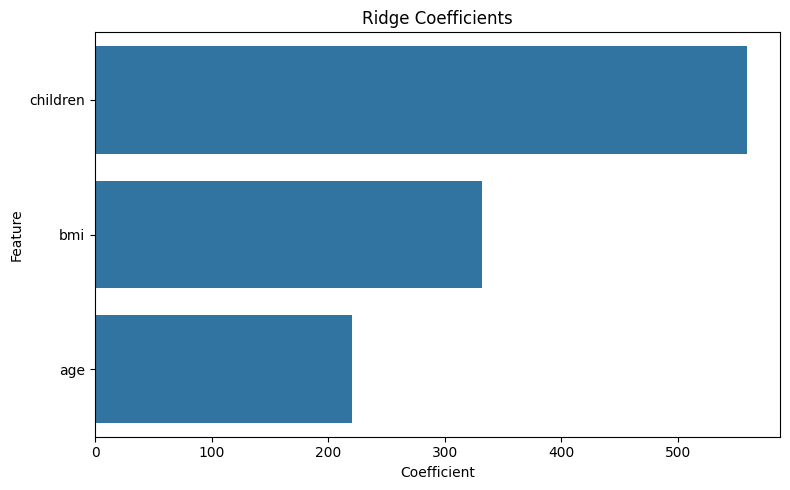


Lasso Best Params: {'alpha': 10}
Lasso Metrics:
MSE: 131200899.47, MAE: 9181.84, R²: 0.15
Coefficients: [220.75735051 331.9216528  556.24328155], Intercept: -6101.943356479986


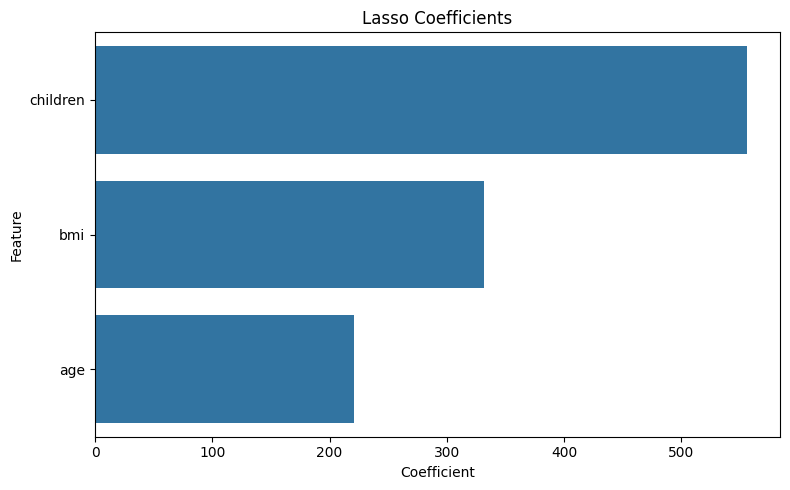


ElasticNet Best Params: {'alpha': 1, 'l1_ratio': 0.7}
ElasticNet Metrics:
MSE: 131193487.14, MAE: 9188.43, R²: 0.15
Coefficients: [221.07123605 329.29253751 467.34240808], Intercept: -5935.494504514469


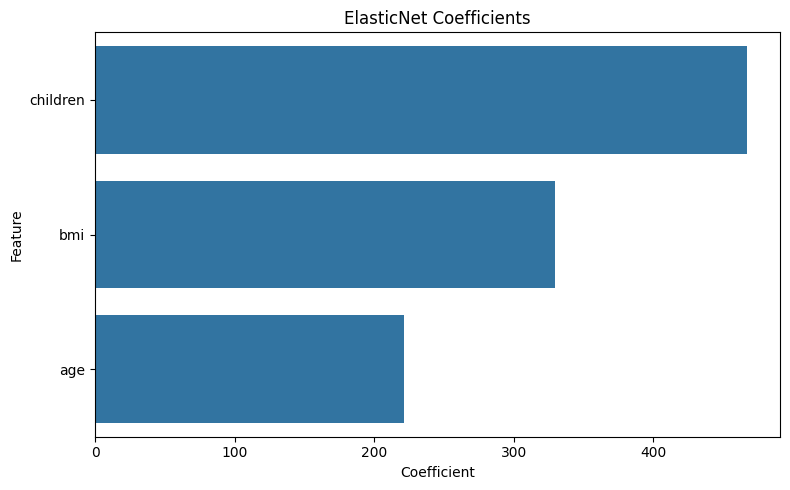

In [ ]:
models = {
    "Ridge": (Ridge(), {'alpha': [0.01, 0.1, 1, 10]}),
    "Lasso": (Lasso(), {'alpha': [0.01, 0.1, 1, 10]}),
    "ElasticNet": (ElasticNet(), {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.5, 0.7]})
}

best_models = {}

for name, (model, params) in models.items():
    grid = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=5)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    print(f"\n{name} Best Params: {grid.best_params_}")
    print(f"{name} Metrics:")
    evaluate_model(y_test, y_pred)
    print(f"Coefficients: {best_model.coef_}, Intercept: {best_model.intercept_}")

    coeff_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': best_model.coef_})
    coeff_df.sort_values(by='Coefficient', key=abs, ascending=False, inplace=True)
    plt.figure(figsize=(8,5))
    sns.barplot(x='Coefficient', y='Feature', data=coeff_df)
    plt.title(f'{name} Coefficients')
    plt.tight_layout()
    plt.show()

    best_models[name] = best_model

5. Датасет и подготовка данных, этап 2:
   - Использовать датафреймы после разбиения на обучающую и тестовую выборки из 1 этапа с категориальными признаками.
   - Закодировать категориальные признаки в обучающей и тестовой выборках.

In [ ]:
X_train_cat = X_train_raw.copy()
X_test_cat = X_test_raw.copy()
y_train_cat = y_train_raw.copy()
y_test_cat = y_test_raw.copy()

categorical_cols = ['sex', 'smoker', 'region']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', LinearRegression())])
pipeline_lr.fit(df.drop('charges', axis=1), df['charges'])

X_train_full = df.drop('charges', axis=1).loc[X_train.index]
X_test_full = df.drop('charges', axis=1).loc[X_test.index]
y_train_full = df['charges'].loc[y_train.index]
y_test_full = df['charges'].loc[y_test.index]

def fit_evaluate_model_with_cat(model_name, model, X_train, y_train, X_test, y_test):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"\n{model_name} with Categorical Features:")
    evaluate_model(y_test, y_pred)
    return pipeline

lr_full = fit_evaluate_model_with_cat("Linear Regression", LinearRegression(), X_train_full, y_train_full, X_test_full, y_test_full)

for name in best_models:
    fit_evaluate_model_with_cat(name, best_models[name], X_train_full, y_train_full, X_test_full, y_test_full)


best_full_model = lr_full


Linear Regression with Categorical Features:
MSE: 33596915.85, MAE: 4181.19, R²: 0.78

Ridge with Categorical Features:
MSE: 33890929.89, MAE: 4238.82, R²: 0.78

Lasso with Categorical Features:
MSE: 33683431.31, MAE: 4189.39, R²: 0.78

ElasticNet with Categorical Features:
MSE: 59743560.84, MAE: 5765.69, R²: 0.62


6. Регрессии, этап 2:
   - Обучить `LinearRegression`, лучшие модели `Ridge`, `LASSO`, `Elastic Net` на обучающем наборе с категориальными признаками.
   - Вывести значения гиперпараметров, коэффициенты регрессии (`model.coef_` и `model.intercept_`) и значения метрик на тестовом наборе ($MSE$, $MAE$ и $R^2$).
   - Сравнить метрики с наличием категориальных признаков и без для каждой из моделей.
   - Выбрать лучшую модель.
   - Построить график (`barh`) с важностью коэфициентов при соответствующих признаках (сверху вниз расположены коэффициенты по убыванию, а названия соответствующих признаков подписаны по вертикальной оси).
   - Осуществить фильтрацию признаков с использованием `Recursive Feature Elimination`.
   - Построить график (`barh`) с важностью коэфициентов при соответствующих признаках (сверху вниз расположены коэффициенты по убыванию, а названия соответствующих признаков подписаны по вертикальной оси).
   - Вывести значения метрик на тестовом наборе ($MSE$, $MAE$ и $R^2$).


RFE Model Metrics:
MSE: 131201335.65, MAE: 9181.31, R²: 0.15


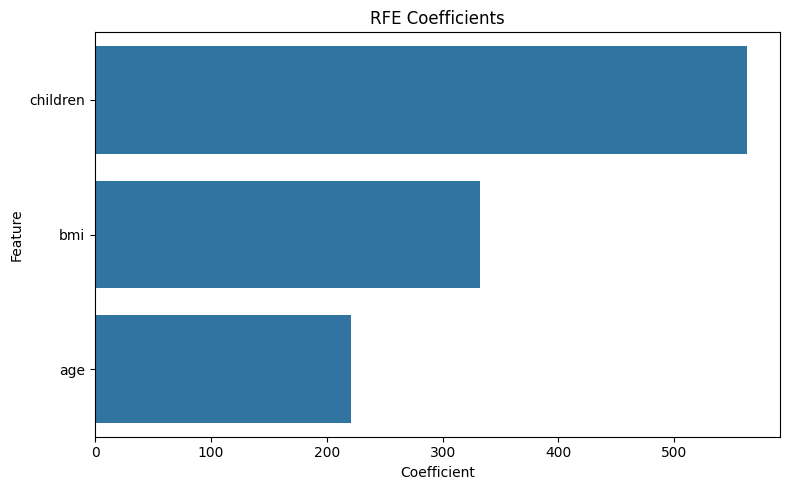

In [ ]:
rfe = RFE(estimator=LinearRegression(), n_features_to_select=3)
rfe.fit(X_train, y_train)

X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

lr_rfe = LinearRegression()
lr_rfe.fit(X_train_rfe, y_train)
y_pred_rfe = lr_rfe.predict(X_test_rfe)

print("\nRFE Model Metrics:")
evaluate_model(y_test, y_pred_rfe)

selected_features = X.columns[rfe.support_]
coeffs = lr_rfe.coef_
coeff_df = pd.DataFrame({'Feature': selected_features, 'Coefficient': coeffs})
coeff_df.sort_values(by='Coefficient', key=abs, ascending=False, inplace=True)
plt.figure(figsize=(8,5))
sns.barplot(x='Coefficient', y='Feature', data=coeff_df)
plt.title('RFE Coefficients')
plt.tight_layout()
plt.show()

7. Сделать вывод:
   - Лучший регрессор, обученный на данных без категориальных признаков (значения метрик на тестовом наборе).
   - Лучший регрессор, обученный на данных с категориальными признаками (значения метрик на тестовом наборе).
   - Вывод о результатах использования `Recursive Feature Elimination` (лучше или хуже - значения метрик).


| Сценарий | Лучшая модель | MSE | MAE | R² |
|----------|----------------|------------|-----------|------|
| Без категориальных признаков | ElasticNet | 131,193,487 | 9,188.43 | 0.15 |
| С категориальными признаками | LinearRegression | **33,596,916** | **4,181.19** | **0.78** |
| После RFE | LinearRegression (на 3 признаках) | 131,201,336 | 9,181.31 | 0.15 |

- **Добавление категориальных признаков значительно улучшило качество модели.**
- **RFE не помогло улучшить результаты**, и даже привело к ухудшению метрик.
- **Лучшей моделью в задаче является линейная регрессия с учетом категориальных признаков.**